In [1]:
import os
import gc
import glob
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei')
import seaborn as sns

from statsmodels.tsa.stattools import coint

# 設定 pandas 顯示完整欄位
pd.set_option('display.max_columns', None)

# 設定資料夾（請根據實際路徑修改）
DATA_DIR = "D:\\Data\\Kline\\UsdFutures"
file_list = glob.glob(os.path.join(DATA_DIR, '*USDT.csv'))
print(f"找到 {len(file_list)} 個 CSV 檔案")

# 只保留成交量排名前 N 的市場
N_top = 150

# 移動平均視窗（用於降噪）與 chunk 設定
WINDOW = 15          # 例如5分鐘移動平均
CHUNK_SIZE = None   # 若資料量龐大，可設定 chunk size

# CSV 欄位名稱（請依實際 CSV 調整）
TIME_COL = 'OpenTime'
PRICE_COL = 'ClosePrice'
VOLUME_COL = 'QuoteVolume'

# 並行計算使用的核心數（本例中利用 64 核 CPU）
n_jobs = 60

# 為方便後續計算，定義最低重疊資料筆數（例如：7天資料，7*24*60=10080筆）
MIN_OVERLAP = 10080


找到 348 個 CSV 檔案


In [2]:
def process_single_csv(file_path, 
                       time_col=TIME_COL, 
                       price_col=PRICE_COL,  # 使用 ClosePrice
                       volume_col=VOLUME_COL,  # 新增成交量欄位
                       window=WINDOW, 
                       chunksize=CHUNK_SIZE):
    """
    讀取單一 CSV，計算 log_price 與對數收益率（移動平均降噪），
    同時保留成交量資訊。回傳 DataFrame 包含 [time_col, symbol, log_price, smoothed_log_return, volume_col]
    """
    # 根據檔名取得市場代號，例如 'BTCUSDT.csv' -> 'BTCUSDT'
    symbol = os.path.splitext(os.path.basename(file_path))[0]
    df_list = []
    
    if chunksize is None:
        df_raw = pd.read_csv(file_path)
        # 保留時間、價格、成交量欄位
        df_raw = df_raw[[time_col, price_col, volume_col]].dropna()
        df_raw.sort_values(by=time_col, inplace=True)
        
        # 計算 log_price 與對數收益率
        df_raw['log_price'] = np.log(df_raw[price_col])
        df_raw['log_return'] = df_raw['log_price'].diff()
        df_raw['smoothed_log_return'] = df_raw['log_return'].rolling(window, min_periods=1).mean()
        df_raw['symbol'] = symbol
        
        # 刪除第一筆因 diff 產生 NaN 的資料
        df_raw.dropna(subset=['smoothed_log_return'], inplace=True)
        df_list.append(df_raw[[time_col, 'symbol', 'log_price', 'smoothed_log_return', volume_col]])
        
        del df_raw
        gc.collect()
    else:
        reader = pd.read_csv(file_path, chunksize=chunksize)
        prev_log_price = None
        for chunk in reader:
            chunk = chunk[[time_col, price_col, volume_col]].dropna()
            chunk.sort_values(by=time_col, inplace=True)
            chunk['log_price'] = np.log(chunk[price_col])
            if prev_log_price is not None:
                chunk.loc[chunk.index[0], 'log_return'] = chunk.loc[chunk.index[0], 'log_price'] - prev_log_price
            chunk['log_return'] = chunk['log_price'].diff()
            chunk['smoothed_log_return'] = chunk['log_return'].rolling(window, min_periods=1).mean()
            prev_log_price = chunk.loc[chunk.index[-1], 'log_price']
            chunk['symbol'] = symbol
            chunk.dropna(subset=['smoothed_log_return'], inplace=True)
            df_list.append(chunk[[time_col, 'symbol', 'log_price', 'smoothed_log_return', volume_col]])
            
            del chunk
            gc.collect()
    
    if len(df_list) > 0:
        df_final = pd.concat(df_list, ignore_index=True)
    else:
        df_final = pd.DataFrame(columns=[time_col, 'symbol', 'log_price', 'smoothed_log_return', volume_col])
        
    return df_final

# 使用修改後的 process_single_csv 讀取所有市場資料
processed_data = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(process_single_csv)(file) for file in file_list
)

# 合併所有市場資料
df_all = pd.concat(processed_data, ignore_index=True)
del processed_data
gc.collect()

print("所有市場資料讀取完成，總筆數：", len(df_all))
df_all.head()


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   8 tasks      | elapsed:    3.3s
[Parallel(n_jobs=60)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=60)]: Done  42 tasks      | elapsed:   14.0s
[Parallel(n_jobs=60)]: Done  61 tasks      | elapsed:   19.4s
[Parallel(n_jobs=60)]: Done  80 tasks      | elapsed:   23.7s
[Parallel(n_jobs=60)]: Done 101 tasks      | elapsed:   27.6s
[Parallel(n_jobs=60)]: Done 122 tasks      | elapsed:   31.1s
[Parallel(n_jobs=60)]: Done 145 tasks      | elapsed:   34.2s
[Parallel(n_jobs=60)]: Done 168 tasks      | elapsed:   37.2s
[Parallel(n_jobs=60)]: Done 193 tasks      | elapsed:   40.8s
[Parallel(n_jobs=60)]: Done 218 tasks      | elapsed:   46.4s
[Parallel(n_jobs=60)]: Done 264 out of 348 | elapsed:  1.0min remaining:   19.3s
[Parallel(n_jobs=60)]: Done 299 out of 348 | elapsed:  1.1min remaining:   10.8s
[Parallel(n_jobs=60)]: Done 334 out of 348 | elapsed:  1.2min remaining:    2.9

所有市場資料讀取完成，總筆數： 281877438


,OpenTime,symbol,log_price,smoothed_log_return,QuoteVolume
0,1645747260000,1INCHUSDT,0.285630,-0.006965,143985.2927
1,1645747320000,1INCHUSDT,0.284953,-0.003821,188617.7024
2,1645747380000,1INCHUSDT,0.286306,-0.002096,27947.5508
3,1645747440000,1INCHUSDT,0.286081,-0.001629,43621.6328
4,1645747500000,1INCHUSDT,0.288257,-0.000868,36284.7832


In [7]:
gc.collect()
# 將時間轉為 datetime（根據資料單位調整，這裡假設單位是 ms）
df_all[TIME_COL] = pd.to_datetime(df_all[TIME_COL], unit='ms', errors='coerce')
df_all.dropna(subset=[TIME_COL], inplace=True)

# 建立字典，每個 symbol 對應一個 DataFrame（包含成交量欄位）
market_dict = {symbol: df.copy() for symbol, df in df_all.groupby('symbol')}
print(f"共 {len(market_dict)} 個市場")
# 如果後續分析不需要成交量欄位，可以選擇刪除
for symbol in market_dict:
    # 例如，只保留必須的欄位
    market_dict[symbol] = market_dict[symbol][[TIME_COL, 'symbol', 'log_price', 'smoothed_log_return', VOLUME_COL]]
gc.collect()

# 清除大表
del df_all
gc.collect()


共 348 個市場


0

In [8]:
# 計算每個市場每小時的成交量總和，再取平均值
avg_volumes = {}
for symbol, df in market_dict.items():
    # 假設 market_dict 中的 DataFrame 之前已包含 VOLUME_COL
    # 若之前已刪除 VOLUME_COL，請改從原始資料來源或另一份副本中取得成交量資訊
    # 這裡示範如何計算：請先將 market_dict 從原始資料重建，或在第一步前保留一份副本
    df_temp = df.copy()  # 假設 df_temp 包含 VOLUME_COL
    # 如果時間未設置索引，需先轉換
    df_temp[TIME_COL] = pd.to_datetime(df_temp[TIME_COL], unit='ms', errors='coerce')
    df_temp.set_index(TIME_COL, inplace=True)
    # 將成交量欄位轉為數值型態
    df_temp[VOLUME_COL] = pd.to_numeric(df_temp[VOLUME_COL], errors='coerce')
    hourly_volume = df_temp[VOLUME_COL].resample('1H').sum()
    avg_volumes[symbol] = hourly_volume.mean()

df_vol = pd.DataFrame(list(avg_volumes.items()), columns=['symbol', 'avg_hourly_volume'])
df_vol = df_vol.sort_values(by='avg_hourly_volume', ascending=False)

print("成交量排名前 10 的市場：")
display(df_vol.head(10))

top_symbols = df_vol.head(N_top)['symbol'].tolist()
print(f"保留成交量排名前 {N_top} 的市場，共 {len(top_symbols)} 個")

# 更新 market_dict：假設這裡使用原始資料（含成交量），篩選後再刪除 VOLUME_COL
market_dict_filtered = {}
for symbol in top_symbols:
    if symbol in market_dict:
        df = market_dict[symbol].copy()
        # 如果後續配對分析不需要成交量，這裡刪除成交量欄位（若存在）
        if VOLUME_COL in df.columns:
            df.drop(columns=[VOLUME_COL], inplace=True)
        market_dict_filtered[symbol] = df

print(f"過濾後市場數量： {len(market_dict_filtered)}")
market_dict = market_dict_filtered
del market_dict_filtered, df_vol, avg_volumes
gc.collect()


C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_10768\3633445031.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_volume = df_temp[VOLUME_COL].resample('1H').sum()
C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_10768\3633445031.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_volume = df_temp[VOLUME_COL].resample('1H').sum()
C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_10768\3633445031.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_volume = df_temp[VOLUME_COL].resample('1H').sum()
C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_10768\3633445031.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_volume = df_temp[VOLUME_COL].resample('1H').sum()
C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_10768\3633445031.py:13: FutureWarnin

成交量排名前 10 的市場：


C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_10768\3633445031.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_volume = df_temp[VOLUME_COL].resample('1H').sum()
C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_10768\3633445031.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_volume = df_temp[VOLUME_COL].resample('1H').sum()
C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_10768\3633445031.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_volume = df_temp[VOLUME_COL].resample('1H').sum()


,symbol,avg_hourly_volume
66,BTCUSDT,5.924462e+08
114,ETHUSDT,3.122264e+08
303,TRUMPUSDT,1.505319e+08
164,KAITOUSDT,1.063863e+08
272,SOLUSDT,7.805657e+07
334,XRPUSDT,4.254811e+07
97,DOGEUSDT,4.071595e+07
158,IPUSDT,3.510696e+07
234,PNUTUSDT,3.364351e+07
207,NEIROUSDT,3.295067e+07


保留成交量排名前 150 的市場，共 150 個
過濾後市場數量： 150


0

In [9]:
# 將所有市場資料合併成一個大表（不填補缺失值）
all_data = pd.concat(market_dict.values(), ignore_index=True)

# 注意：此處的 timestamp 應已轉成 datetime 格式
# 建立 pivot 表：index 為 timestamp，columns 為 symbol，值為 smoothed_log_return
pivot_df = all_data.pivot(index=TIME_COL, columns='symbol', values='smoothed_log_return')
print("寬格式資料形狀:", pivot_df.shape)

# 查看前幾筆（保留缺失值，不填 0）
pivot_df.head()

# 釋放暫存
del all_data
gc.collect()


寬格式資料形狀: (1578240, 150)


0

In [10]:
# 計算皮爾遜相關係數矩陣（缺失值自動忽略，只用重疊部分）
cor_matrix = pivot_df.corr(method='pearson', min_periods=MIN_OVERLAP)
print("相關矩陣大小:", cor_matrix.shape)
cor_matrix.head()

# 釋放 pivot_df（若後續不再使用）
del pivot_df
gc.collect()


相關矩陣大小: (150, 150)


0

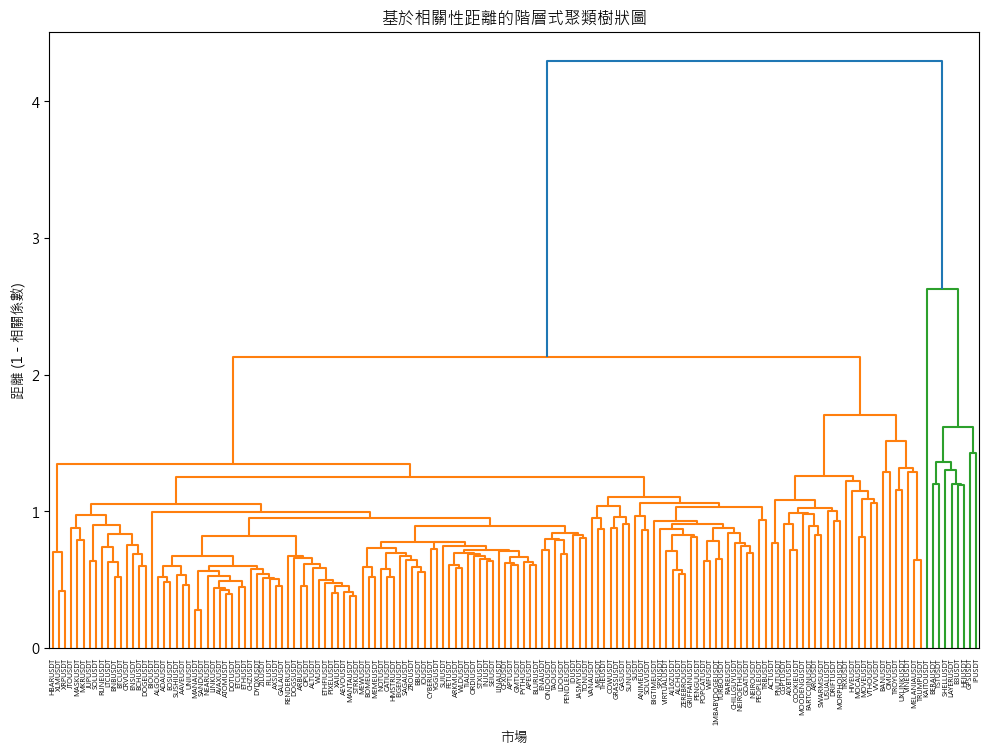

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram

# 填補 NaN 值 (若某些市場間無足夠重疊，將其視為相關性 0)
cor_matrix_filled = cor_matrix.fillna(0)

# 以相關矩陣建立距離矩陣 (d = 1 - correlation)
dist_matrix = 1 - cor_matrix_filled

# 檢查是否有非有限值
if not np.all(np.isfinite(dist_matrix)):
    raise ValueError("距離矩陣中仍含有非有限值！")

# 使用 average linkage 進行階層式聚類
Z = linkage(dist_matrix, method='average')

# 繪製樹狀圖
plt.figure(figsize=(12, 8))
dendrogram(Z, labels=cor_matrix.columns, leaf_rotation=90)
plt.title("基於相關性距離的階層式聚類樹狀圖")
plt.xlabel("市場")
plt.ylabel("距離 (1 - 相關係數)")
plt.show()



In [12]:
import itertools

# 取得所有市場列表
symbols = cor_matrix.columns.tolist()

# 產生所有不重複的市場對 (i < j)
pairs = []
for i in range(len(symbols)):
    for j in range(i+1, len(symbols)):
        m1 = symbols[i]
        m2 = symbols[j]
        corr_value = cor_matrix.loc[m1, m2]
        pairs.append((m1, m2, corr_value))

# 按相關係數由大到小排序（降冪排序）
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

# 根據條件挑選 5 組配對：市場間不能重複出現
selected_pairs = []
used_markets = set()

for pair in pairs_sorted:
    m1, m2, corr_value = pair
    if m1 not in used_markets and m2 not in used_markets:
        selected_pairs.append(pair)
        used_markets.add(m1)
        used_markets.add(m2)
    if len(selected_pairs) == 5:
        break

print("挑選出的 5 組最佳且市場不重複的配對：")
for m1, m2, corr_value in selected_pairs:
    print(f"{m1} <--> {m2} : 相關係數 = {corr_value:.4f}")

# 釋放不再需要的記憶體
del pairs, pairs_sorted
gc.collect()


挑選出的 5 組最佳且市場不重複的配對：
AEVOUSDT <--> RENDERUSDT : 相關係數 = 0.7497
ALGOUSDT <--> DOTUSDT : 相關係數 = 0.7351
AAVEUSDT <--> ETHUSDT : 相關係數 = 0.7317
DYDXUSDT <--> STRKUSDT : 相關係數 = 0.7228
EIGENUSDT <--> ETHFIUSDT : 相關係數 = 0.7190


16654

c:\Users\Kenneth\.conda\envs\Quant\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.draw()
c:\Users\Kenneth\.conda\envs\Quant\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


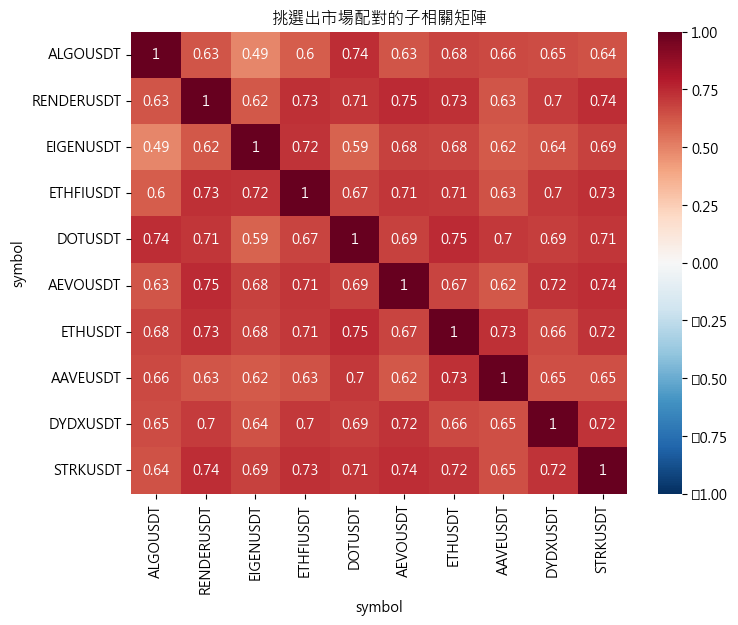

In [13]:
# 將挑選出的市場名稱整理
selected_markets = []
for m1, m2, _ in selected_pairs:
    selected_markets.extend([m1, m2])
selected_markets = list(set(selected_markets))  # 應該有 10 個不同市場

# 從完整相關矩陣中取出這些市場的子矩陣
sub_cor = cor_matrix.loc[selected_markets, selected_markets]

plt.figure(figsize=(8, 6))
sns.heatmap(sub_cor, annot=True, cmap="RdBu_r", vmin=-1, vmax=1)
plt.title('挑選出市場配對的子相關矩陣')
plt.show()
